# Problem: Recommend Movies or Shows to Users

Modified from:
- [Implementing a Recommender System with SageMaker, MXNet, and Gluon](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_applying_machine_learning/gluon_recommender_system/gluon_recommender_system.ipynb)
- [An Introduction to Factorization Machines with MNIST](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/factorization_machines_mnist/factorization_machines_mnist.ipynb)
- [Extending Amazon SageMaker Factorization Machines Algorithm to Predict Top X Recommendations](https://aws.amazon.com/blogs/machine-learning/extending-amazon-sagemaker-factorization-machines-algorithm-to-predict-top-x-recommendations/)

## Introduction to business scenario

You work for a startup that focuses on delivering on-demand video streaming services to users. The company wants to introduce movie/show recommendations for their users based on their viewing history.

You are tasked with solving part of this problem by leveraging machine learning to create a recommendation engine to be used on the user website. You are given access to the dataset of historical user preferences and the movies they watched. You can use this to train a machine learning model to recommend movies/shows to watch.

## About this dataset  
The Amazon Customer Reviews Dataset is a collection of reviews on different products from the Amazon.com marketplace from 1995 until 2015. Customer reviews are one of the most important data types at Amazon. Collecting and showing reviews has been part of the Amazon culture since the beginning of the company and is arguably one important source of innovation. For more details on this dataset, see [Amazon Customer Reviews Dataset](https://s3.amazonaws.com/amazon-reviews-pds/readme.html).

This exercise focuses on reviews of videos. The videos dataset contains 1- to 5-star ratings from over 2M Amazon customers on 160K digital videos.

### Features

**Data columns**

- `marketplace`: Two-letter country code (in this case, all "US")
- `customer_id`: Random identifier that can be used to aggregate reviews written by a single author
- `review_id`: Unique ID for the review
- `product_id`: Amazon Standard Identification Number (ASIN). http://www.amazon.com/dp/<ASIN\> links to the product's detail page.
- `product_parent`: The parent of that ASIN. Multiple ASINs (color or format variations of the same product) can roll up into a single parent.
- `product_title`: Title description of the product
- `product_category`: Broad product category that can be used to group reviews (in this case, digital videos)
- `star_rating`: Product's rating (1 to 5 stars)
- `helpful_votes`: Number of helpful votes for the review
- `total_votes`: Number of total votes the review received
- `vine`: Was the review written as part of the Vine program?
- `verified_purchase`: Was the review from a verified purchase?
- `review_headline`: Title of the review itself
- `review_body`: Text of the review
- `review_date`: Date the review was written


**Data format**
- Tab `\t` separated text file, without quote or escape characters
- First line in each file is header; 1 line corresponds to 1 record

### Dataset attributions

Website: https://s3.amazonaws.com/amazon-reviews-pds/readme.html

This dataset is being provided to you by permission of Amazon and is subject to the terms of the AWS Digital Training Service Agreement (available at https://aws.amazon.com/training/digital-training-agreement). You are expressly prohibited from copying, modifying, selling, exporting, or using this dataset in any way other than for the purpose of completing this lab.

## Brainstorming and designing a question...

...That you can answer with machine learning. 

The first step in most projects is to think about the question you want to ask, how the data available supports this question, and which tool (in this case, machine learning model) you are going to use to answer the question. This is an important step because it helps narrow the scope of exploration and gives clarity on the features that you are going to use. 

Take a moment to write your thoughts regarding the dataset in the cell below. What are the things you can predict with machine learning? Why may that be relevant from a business/client perspective? Explain why you consider these thoughts important.

#### Ideas

- Recommend movies to user's based on other user's likings, example: Neflix ALS algorithm
- Predict a user review to a movie they haven't seen yet
- Can we use sentiment analysis on the Review for a little more information about what the user tought about the movie.

There might be several ideas about what to do with the data, but for now we are all going to work on recommending a video to a particular user.

## Recommendation and factorization machines

In many ways, recommender systems were a catalyst for the current popularity of machine learning. One of Amazon's earliest successes was the "Customers who bought this, also bought..." feature. The million dollar Netflix Prize spurred research, raised public awareness, and inspired numerous other data science competitions.

Recommender systems can utilize a multitude of data sources and machine learning algorithms. Most combine various unsupervised, supervised, and reinforcement learning techniques into a holistic framework. However, the core component is almost always a model that predicts a user's rating (or purchase) for a certain item based on that user's historical ratings of similar items as well as the behavior of other similar users. The minimal required dataset for this is a history of user item ratings (which we have).

The method that you'll use is a factorization machine. A factorization machine is a general-purpose supervised learning algorithm that you can use for both classification and regression tasks. It is an extension of a linear model and is designed to parsimoniously (simply) capture interactions between features in high-dimensional sparse datasets. This makes it a good candidate to handle data patterns with features such as click prediction and item recommendation.

# Step 1: Problem formulation and data collection

Start this project off by writing a few sentences below that summarize the business problem and the business goal you're trying to achieve in this scenario. Include a business metric you would like your team to aspire toward. With that information defined, clearly write out the machine learning problem statement. Finally, add a comment or two about the type of machine learning this represents.

#### <span style="color: blue;">Project presentation: Include a summary of these details in your project presentations.</span>

### Read through a business scenario and:

### 1. Determine if and why ML is an appropriate solution to deploy.

- ML is appropriate, as we have a large dataset of products and users to work with, doing a manual job for this would be an infinite task, and cost a lot more than simply employing machines for what they do best, detecting patterns. 

### 2. Formulate the business problem, success metrics, and desired ML output.

- As a company, we need to increase user retention in the platform, by providing them with useful recommendations, that will drive them to watch more content in the platform.
- A success metric would be measuring the average watch time, and mesure if it has improved retention.
- Another way to measure success would be the click through rate on recommendations, and once they are clicked, how many of them are then watched by the user it was recommended to.

### 3. Identify the type of ML problem you’re dealing with.

- This is an Association rule learning problem, where the model will try to predict associated movies for a user, given the history of other movies that user as watched and rated. 

### 4. Analyze the appropriateness of the data you’re working with.

- The data has all the necessary information available, there are some extraneous information that may be removed as it does not relate to the problem at hand (e.g.: marketplace, review_id, etc)

### Setup

Now that we have decided where to focus our energy, let's set things up so you can start working on solving the problem.

**Note:** This notebook was created and tested on an `ml.m4.xlarge` notebook instance. 

Start by specifying:
- The Amazon Simple Storage Service (Amazon S3) bucket and prefix(?) that you want to use for training and model data. This should be within the same Region as the Notebook Instance, training, and hosting.
- The AWS Identity and Access Management (IAM) role [Amazon Resource Name (ARN)](https://docs.aws.amazon.com/general/latest/gr/aws-arns-and-namespaces.html) used to give training and hosting access to your data. See the documentation for how to create these.

**Note:** If more than one role is required for notebook instances, training, and/or hosting, replace the `get_execution_role()` call with the appropriate full IAM role ARN string(s).

Replace **`<LabBucketName>`** with the resource name that was provided with your lab account.

In [41]:
# Change the bucket and prefix according to your information
bucket = 'qls-4019912-5ead0778b062168c-labbucket-1h2g0kyyebu6d'
prefix = 'sagemaker-fm' 

import sagemaker
role = sagemaker.get_execution_role()

Now, load some Python libraries you'll need for the remainder of this example notebook.

In [42]:
import os, subprocess
import warnings
import pandas as pd
import numpy as np
import sagemaker
from sagemaker.mxnet import MXNet
import boto3
import json
import matplotlib.pyplot as plt
import seaborn as sns

# Add this to display all the outputs in the cell and not just the last one
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Ignore warnings
warnings.filterwarnings("ignore")

# Step 2: Data preprocessing and visualization 
In this data preprocessing phase, you should take the opportunity to explore and visualize your data to better understand it. First, import the necessary libraries and read the data into a Pandas dataframe. After that, explore your data. Look for the shape of the dataset and explore your columns and the types of columns you're working with (numerical, categorical). Consider performing basic statistics on the features to get a sense of feature means and ranges. Take a close look at your target column and determine its distribution.

### Specific questions to consider
1. What can you deduce from the basic statistics you ran on the features? 

2. What can you deduce from the distributions of the target classes?

3. Is there anything else you deduced from exploring the data?

#### <span style="color: blue;">Project presentation: Include a summary of your answers to these and other similar questions in your project presentations.</span>

Start by bringing in the dataset from an Amazon S3 public bucket to this notebook environment.

In [43]:
# Check whether the file is already in the desired path or if it needs to be downloaded

base_path = '/home/ec2-user/SageMaker/project/data/AmazonReviews'
file_path = '/amazon_reviews_us_Digital_Video_Download_v1_00.tsv.gz'

if not os.path.isfile(base_path + file_path):
    subprocess.run(['mkdir', '-p', base_path])
    subprocess.run(['aws', 's3', 'cp', 's3://amazon-reviews-pds/tsv' + file_path, base_path])
else:
    print('File already downloaded!')

File already downloaded!


### Reading the dataset

Read the data into a Pandas dataframe so that you can know what you are dealing with.

**Note:** You'll set `error_bad_lines=False` when reading the file in, because there appear to be a very small number of records that would create a problem otherwise.

**Hint:** You can use the built-in Python `read_csv` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html)). You can use the file path directly with Pandas `read_csv` with `delimiter='\t'`.

For example: `pd.read_csv('filename.tar.gz', delimiter = '\t', error_bad_lines=False)`

In [44]:
df = pd.read_csv('/'.join([base_path, file_path]), delimiter = '\t', error_bad_lines=False)

b'Skipping line 92523: expected 15 fields, saw 22\n'
b'Skipping line 343254: expected 15 fields, saw 22\n'
b'Skipping line 524626: expected 15 fields, saw 22\n'
b'Skipping line 623024: expected 15 fields, saw 22\n'
b'Skipping line 977412: expected 15 fields, saw 22\n'
b'Skipping line 1496867: expected 15 fields, saw 22\n'
b'Skipping line 1711638: expected 15 fields, saw 22\n'
b'Skipping line 1787213: expected 15 fields, saw 22\n'
b'Skipping line 2395306: expected 15 fields, saw 22\n'
b'Skipping line 2527690: expected 15 fields, saw 22\n'


Print the first few rows of your dataset.  

**Hint**: Use the `pandas.head(<number>)` function to print the rows.

In [45]:
df.head(10)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,12190288,R3FU16928EP5TC,B00AYB1482,668895143,Enlightened: Season 1,Digital_Video_Download,5,0,0,N,Y,I loved it and I wish there was a season 3,I loved it and I wish there was a season 3... ...,2015-08-31
1,US,30549954,R1IZHHS1MH3AQ4,B00KQD28OM,246219280,Vicious,Digital_Video_Download,5,0,0,N,Y,As always it seems that the best shows come fr...,As always it seems that the best shows come fr...,2015-08-31
2,US,52895410,R52R85WC6TIAH,B01489L5LQ,534732318,After Words,Digital_Video_Download,4,17,18,N,Y,Charming movie,"This movie isn't perfect, but it gets a lot of...",2015-08-31
3,US,27072354,R7HOOYTVIB0DS,B008LOVIIK,239012694,Masterpiece: Inspector Lewis Season 5,Digital_Video_Download,5,0,0,N,Y,Five Stars,excellant this is what tv should be,2015-08-31
4,US,26939022,R1XQ2N5CDOZGNX,B0094LZMT0,535858974,On The Waterfront,Digital_Video_Download,5,0,0,N,Y,Brilliant film from beginning to end,Brilliant film from beginning to end. All of t...,2015-08-31
5,US,4772040,R1HCST57W334KN,B0112OSOQE,38517795,Rick and Morty Season 2,Digital_Video_Download,5,5,6,N,Y,Best show on TV right now,If you don't like this show. Go back to your n...,2015-08-31
6,US,12910040,R32BUTYQS1ZJBQ,B000NPE5SA,373323715,Africa Screams,Digital_Video_Download,4,1,1,N,Y,Very funny. A typical mid 50's comedy,Very funny. A typical mid 50's comedy.,2015-08-31
7,US,38805573,RH4SXPL4L9QU,B00XWV4QXG,633842417,Entourage: Season 7,Digital_Video_Download,3,0,0,N,Y,it was not as good as the series,"Strange as it is, it was not as good as the se...",2015-08-31
8,US,37100714,R37INWIQA5YW8N,B00X8UKOUK,666093513,Catastrophe - Season 1,Digital_Video_Download,2,0,0,N,Y,Two Stars,"Funny shows! We laughed out loud, alot!",2015-08-31
9,US,41234409,R18GSVAAS3N8GX,B00OOKXTFU,801680808,The Worricker Trilogy Season 1,Digital_Video_Download,3,0,0,N,Y,A tad Stuffy,Well made. Great actors! Christopher Walken ma...,2015-08-31


Now what is the information contained in all the columns?

### Anatomy of the dataset

Get a little more comfortable with the data and see what features are at hand.

- `marketplace`: Two-letter country code (in this case, all "US")
- `customer_id`: Random identifier that can be used to aggregate reviews written by a single author
- `review_id`: Unique ID for the review
- `product_id`: Amazon Standard Identification Number (ASIN). http://www.amazon.com/dp/<ASIN\> links to the product's detail page.
- `product_parent`: The parent of that ASIN. Multiple ASINs (color or format variations of the same product) can roll up into a single parent.
- `product_title`: Title description of the product
- `product_category`: Broad product category that can be used to group reviews (in this case, digital videos)
- `star_rating`: Product's rating (1 to 5 stars)
- `helpful_votes`: Number of helpful votes for the review
- `total_votes`: Number of total votes the review received
- `vine`: Was the review written as part of the Vine program?
- `verified_purchase`: Was the review from a verified purchase?
- `review_headline`: Title of the review itself
- `review_body`: Text of the review
- `review_date`: Date the review was written

### Analyzing and understanding the dataset

#### Exploring the data

**Hint:** You can refer [here](https://pandas.pydata.org/pandas-docs/stable/reference/frame.html) to answer the following questions. 

**Question:** How many rows and columns do you have in the dataset?

Check the size of the dataset.  

**Hint**: Use the `<dataframe>.shape` function to check the size of your dataframe

In [46]:
print(f'Features:\t {df.shape[1]}')
print(f'Data Points:\t {df.shape[0]}')

Features:	 15
Data Points:	 3998345


In [47]:
# Answer: 3998345 rows, 15 columns

**Question:** Which columns contain null values, and how many null values do they contain?

Print a summary of the dataset.  

**Hint**: Use `<dataframe>.info` function using the keyword arguments `null_counts = True`

In [48]:
df.isna().sum()

marketplace            0
customer_id            0
review_id              0
product_id             0
product_parent         0
product_title          0
product_category       0
star_rating            0
helpful_votes          0
total_votes            0
vine                   0
verified_purchase      0
review_headline       25
review_body           78
review_date          138
dtype: int64

In [49]:
# Answer:
#  - review_headline       25
#  - review_body           78
#  - review_date          138

**Question:** Are there any duplicate rows? If yes, how many are there?  

**Hint**: Filter the dataframe using `dataframe.duplicated()` ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.duplicated.html#pandas.DataFrame.duplicated)) and check the length of the new dataframe.

In [50]:
duplicates = df.duplicated()

# Enter your code here
duplicates.sum()

0

In [51]:
# Answer: There are no duplicate rows.

### Data preprocessing

Now it's time to decide what features you are going to use and how you are going to prepare them for your model. For this example, limit yourself to `customer_id`, `product_id`, `product_title`, and `star_rating`. Including additional features in the recommendation system could be beneficial but would require substantial processing (particularly the text data), which would be beyond the scope of this notebook.

Reduce this dataset and only use the columns mentioned.  

**Hint**: Select multiple columns as a dataframe by passing the columns as a list. For example: `df[['column_name 1', 'column_name 2']]`

In [52]:
df_reduced = df[['customer_id', 'product_id', 'product_title', 'star_rating']]

Check again if you have duplicates after reducing the dataset. 

In [53]:
duplicates = df_reduced.duplicated()

# Enter your code here
duplicates.sum()

131

In [54]:
# Answer: Yes, there's 131 duplicate rows.

**Question:** Why do you have duplicates in your dataset now? What changed after you reduced the dataset? Review the first 20 lines of the duplicates. 

**Hint**: Use the `pandas.head(<number>)` function to print the rows.

In [55]:
df_reduced[duplicates].head(20)

,customer_id,product_id,product_title,star_rating
565194,41454255,B00Y2UYRFS,unseen 2,1
594322,17570065,B00R3EEO2G,The Maze Runner,2
611264,15703996,B00I3MQNWG,Bosch Season 1,5
612471,28456429,B008Y6W7J4,Rabbit Hole,5
613791,52388381,B00YORA25I,"McFarland, USA (Theatrical)",5
685156,31828958,B00TT53YSW,"Bates Motel, Season 3",5
1204110,19462,B00QWUL4AW,Exodus: Gods and Kings,5
1564816,24892653,B00L2GPYKW,The Escape Artist Season 1,5
1601662,44513234,B00NY4UIKG,The Equalizer,5
1616429,43345475,B00P5968FC,The Babadook,3


**Hint:** Take a look at the first two elements in the duplicates dataframe, and query the original dataframe df to see what the data looks like. You can use the `query` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.query.html)).

For example:

```
df_eg = pd.DataFrame({
            'A': [1,2,3,4],
            'B': [
        })
df_eg.query('A > 1 & B > 0')
```

In [56]:
df.query('customer_id == "41454255" & product_id == "B00Y2UYRFS"')

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
541362,US,41454255,R2F1FQI9DGBJVT,B00Y2UYRFS,542345963,unseen 2,Digital_Video_Download,1,3,3,N,Y,Do Not Waste Any Money On This Horrible Attemp...,Lorenzo Lamas has hit the bottom of the barrel...,2015-06-16
565194,US,41454255,R2WZRCYMUC7LLV,B00Y2UYRFS,542345963,unseen 2,Digital_Video_Download,1,1,1,N,Y,Do NOT spend money on this movie!,Lorenzo Lamas has hit the bottom of the barrel...,2015-06-12


In [57]:
# Answer: That customer has made two reviews for the same movie, 
# with the exact same rating, but with different review titles,
# that could mean they are different reviews, or the dataset has
# all the history of changes of reviews with different review_ids.

Before continuing, remove the duplicate rows.

**Hint**: Use the `~` operator to select all the rows that aren't duplicated. For example:
    
```
df_eg = pd.DataFrame({
            'A': [1,2,3,4],
            'B': [2,0,5,2]
        })
df_eg[~(df_eg['B'] > 0)]
```

In [58]:
df_reduced = df_reduced[~duplicates]

df_reduced.shape

(3998214, 4)

### Visualize some of the rows in the dataset
If you haven't done so in the above, you can use the space below to further visualize some of your data. Look specifically at the distribution of features like `star_rating`, `customer_id`, and `product_id`.

**Specific questions to consider**

1. After looking at the distributions of features, to what extent might those features help your model? Is there anything you can deduce from those distributions that might be helpful in better understanding your data? 

2. Should you use all the data? What features should you use?

3. What month has the highest count of user ratings?

Use the cells below to visualize your data and answer these and other questions that might be of interest to you. Insert and delete cells where needed.

#### <span style="color: blue;">Project presentation: Include a summary of your answers to these and similar questions in your project presentations.</span>

Use `sns.barplot` ([documentation](https://seaborn.pydata.org/generated/seaborn.barplot.html)) to plot the `star_rating` density and distribution.

,index,star_rating
0,5,2410533
1,4,756423
2,3,345891
3,1,289731
4,2,195767


<AxesSubplot:xlabel='index', ylabel='star_rating'>

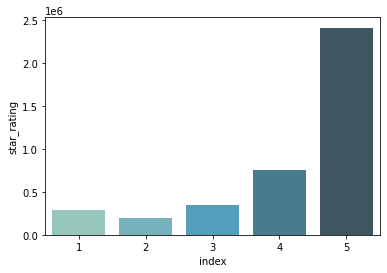

In [59]:
df['star_rating'].value_counts().reset_index()

sns.barplot(
    x='index',
    y='star_rating', # Enter your code here
    data=_,  # The underscore symbol in Python is used to store the output of the last operation
    palette='GnBu_d'
)

**Question:** What month contains the highest count of user ratings?  

**Hint**:  
1. Use `pd.to_datetime` to convert the `review_date` column to a datetime column.  
2. Use the month from the `review_date` column. You can access it for a datetime column using `<column_name>.dt.month`.  
3. Use the `groupby` function using `idxmax`.  

,review_date,star_rating
0,1.0,309083
1,2.0,369059
2,3.0,432084
3,4.0,363611
4,5.0,339285
5,6.0,328114
6,7.0,417844
7,8.0,464912
8,9.0,206453
9,10.0,218583


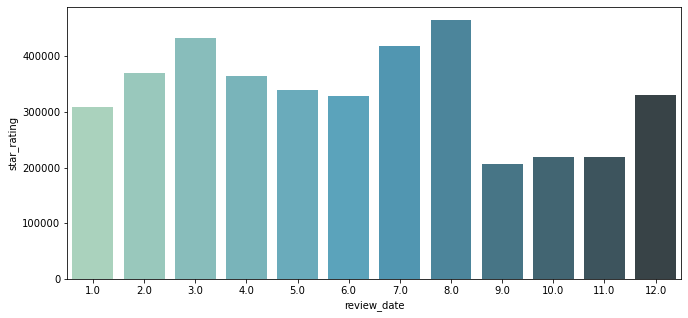

In [60]:
# Convert the review date to a datetime type. Here you will use original dataframe 'df'
df['review_date'] = pd.to_datetime(df['review_date'])

# Count the number of ratings by month
df.groupby(df['review_date'].dt.month).star_rating.count().reset_index()

# Use the bar plot again to plot the ratings(y) vs. review_date(x)
g = sns.barplot(x='review_date', y='star_rating', data=_, palette='GnBu_d') # Enter your code here
g.figure.set_size_inches((11, 5))

In [61]:
# Use the Pandas groupby function on month to get the star rating count
max_month = df.groupby(df['review_date'].dt.month_name()).star_rating.count().idxmax() # Enter your code here
print(f'The month with the most reviews is: {max_month}')

The month with the most reviews is: August


In [62]:
# Answer: The month with most review is August

**Bonus question (optional):** Which years have the most and least reviews?

<AxesSubplot:xlabel='review_date', ylabel='star_rating'>

,review_date,star_rating
15,2015.0,1554812


,review_date,star_rating
0,2000.0,1
1,2001.0,1


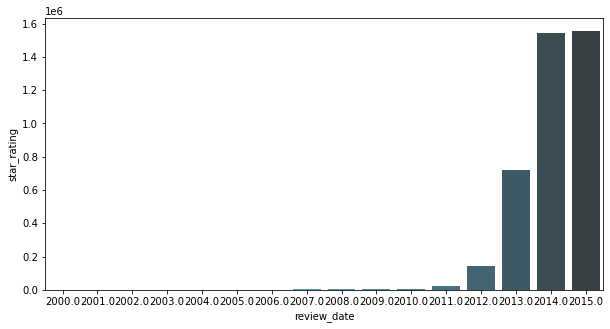

In [63]:
# Use the Pandas groupby function on year and get the star rating count
yearly_df = df.groupby(df['review_date'].dt.year).star_rating.count().reset_index() # Enter your code here

fig = plt.gcf()
fig.set_size_inches(10, 5)

# Use the bar plot to plot star_rating(y) vs. review_date(x)
sns.barplot(x='review_date', y='star_rating', data=yearly_df, palette='GnBu_d') # Enter your code here

yearly_df[yearly_df.star_rating == yearly_df.star_rating.max()]
yearly_df[yearly_df.star_rating == yearly_df.star_rating.min()]

In [64]:
# Answer:
#  - Most reviews: 2015 (1,554,812 reviews)
#  - Least reviews: 2000 and 2001 (1 review)

### Cleaning data

**Question**: How heterogeneous are the number of reviews per customer and reviews per video? Use quantiles to find out.

**Hint**: Use `<dataframe>['columns_name'].value_counts()` for the customers and products dataframe, and use `<dataframe>.quantile(<list>)` to find the relationship.

customers
        customer_id
0.000          1.0
0.010          1.0
0.020          1.0
0.030          1.0
0.040          1.0
0.050          1.0
0.100          1.0
0.250          1.0
0.500          1.0
0.750          2.0
0.900          4.0
0.950          5.0
0.960          6.0
0.970          7.0
0.980          9.0
0.990         13.0
0.995         18.0
0.999         37.0
1.000       2704.0
products
        product_id
0.000       1.000
0.010       1.000
0.020       1.000
0.030       1.000
0.040       1.000
0.050       1.000
0.100       1.000
0.250       1.000
0.500       3.000
0.750       9.000
0.900      31.000
0.950      73.000
0.960      95.000
0.970     130.000
0.980     199.000
0.990     386.670
0.995     699.000
0.999    1993.901
1.000   32790.000


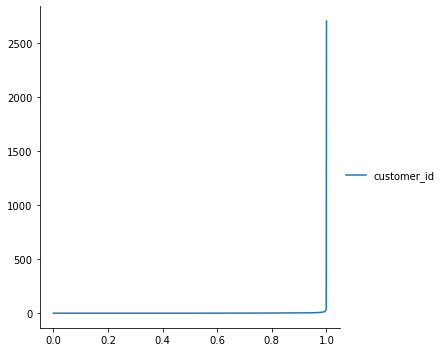

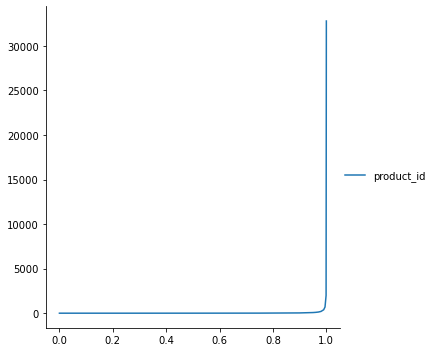

In [65]:
customers = pd.DataFrame(df['customer_id'].value_counts())
products = pd.DataFrame(df['product_id'].value_counts())

quantiles = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.25, 0.5, 
             0.75, 0.9, 0.95, 0.96, 0.97, 0.98, 0.99, 0.995, 
             0.999, 1]
print('customers\n', customers.quantile(quantiles)) # Enter your code here
print('products\n', products.quantile(quantiles)) # Enter your code here

sns.relplot(data=customers.quantile(quantiles), kind='line')
sns.relplot(data=products.quantile(quantiles), kind='line')

In [66]:
# Answer: The long tail is quite steep, with the majority of products and costumers having a low review count

Filter out this long tail. Select the customers that have rated 18 or more videos and the products that have more than 95 reviews. 

In [67]:
customers1 = customers[customers['customer_id'] > 18]
products1 = products[products['product_id'] > 95]

# Use the Pandas merge function to merge the customer1 and products1 with the original df_reduced dataset
reduced_df = (
            df_reduced.merge(pd.DataFrame({'customer_id': customers1.index}))
                      .merge(pd.DataFrame({'product_id': products1.index}))
            )# Enter your code here
reduced_df

,customer_id,product_id,product_title,star_rating
0,11763902,B00PSLQYWE,Downton Abbey Season 5,4
1,1411480,B00PSLQYWE,Downton Abbey Season 5,5
2,35303629,B00PSLQYWE,Downton Abbey Season 5,5
3,21285980,B00PSLQYWE,Downton Abbey Season 5,5
4,29260449,B00PSLQYWE,Downton Abbey Season 5,5
...,...,...,...,...
160037,35249628,B002KQ1K42,Best in Show,4
160038,6579710,B0076PISBK,The Backyardigans,5
160039,20783345,B009NPK1IO,Gossip Girl: The Complete Sixth Season,5
160040,11123322,B009NPK1IO,Gossip Girl: The Complete Sixth Season,5


**Question:** What is the shape of `customers1`, `products1`, and the new dataframe reduced_df?  

**Note**: Use f-strings for this:
```
x= 3
print(f'X = {x}')
```

In [68]:
print(f'Number of users is {customers1.shape[0]} and number of items is {products1.shape[0]}.')# Enter your code here
print(f'Length of reduced df is {reduced_df.shape}.')# Enter your code here

Number of users is 9351 and number of items is 6612.
Length of reduced df is (160042, 4).


Print the first 5 columns of the dataframe.

In [69]:
reduced_df.head(5)

,customer_id,product_id,product_title,star_rating
0,11763902,B00PSLQYWE,Downton Abbey Season 5,4
1,1411480,B00PSLQYWE,Downton Abbey Season 5,5
2,35303629,B00PSLQYWE,Downton Abbey Season 5,5
3,21285980,B00PSLQYWE,Downton Abbey Season 5,5
4,29260449,B00PSLQYWE,Downton Abbey Season 5,5


**Question:** Does `reduced_df` maintain the same ratio of ratings?

,index,star_rating
0,5,79163
1,4,39465
2,3,22784
3,2,10033
4,1,8597


<AxesSubplot:xlabel='index', ylabel='star_rating'>

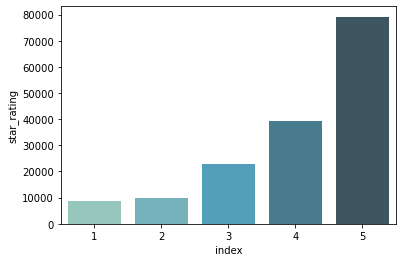

In [70]:
reduced_df['star_rating'].value_counts().reset_index()# Enter your code here
sns.barplot(x='index', y='star_rating', data=_, palette='GnBu_d')

In [71]:
# Answer: Yes, it maintains roughly the same rate and pattern.

Now, recreate the customer and product distributions of count per customer and product.

**Hint**: Use the `value_counts()` function on the `customer_id` and `product_id` columns.

Text(0.5, 0.98, 'Distribution of counts per customer and product')

<AxesSubplot:xlabel='customer_id'>

<AxesSubplot:xlabel='product_id'>

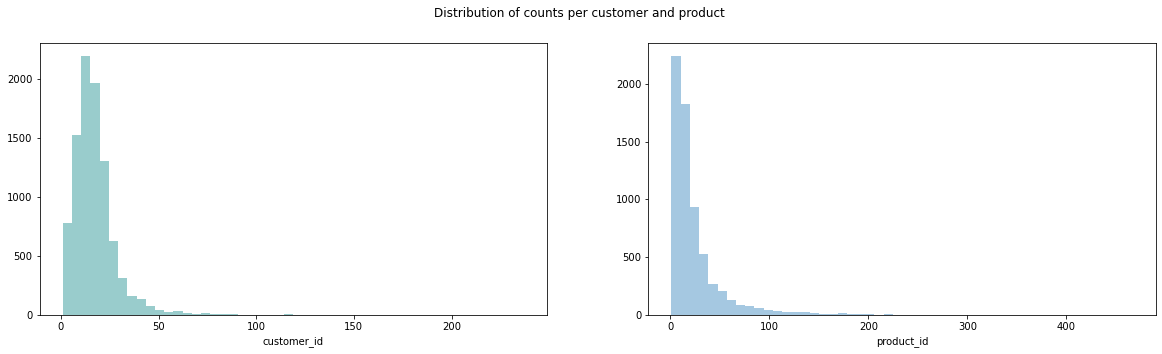

In [72]:
customers = reduced_df['customer_id'].value_counts()
products = reduced_df['product_id'].value_counts()

fig, axs = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle('Distribution of counts per customer and product')
sns.distplot(customers, kde=False, ax=axs[0], color='teal')
sns.distplot(products, kde=False, ax=axs[1])

Next, number each user and item, giving them their own sequential index. This will allow you to hold the information in a sparse format where the sequential indices indicate the row and column in the ratings matrix.

To create the `customer_index` and `product_index`, create a new dataframe with `customer_id` as the index value and a sequential counter/values for the user and item number. Once you are finished creating both indexes, use the Pandas `merge` function to merge `customer_index` with `product_index`.

**Hint**: Use the `shape` function to generate the total number of customers and products. Use `np.arange` to generate a list of numbers from 0 to the number of customers and products.

In [73]:
customer_index = pd.DataFrame({'customer_id': customers.index, 
                               'user': np.arange(customers.shape[0])}) # Enter your code here
product_index = pd.DataFrame({'product_id': products.index, 
                              'item': np.arange(products.shape[0])}) # Enter your code here

reduced_df = reduced_df.merge(customer_index).merge(product_index)# Enter your code here
reduced_df.head()

,customer_id,product_id,product_title,star_rating,user,item
0,11763902,B00PSLQYWE,Downton Abbey Season 5,4,3664,122
1,1411480,B00PSLQYWE,Downton Abbey Season 5,5,136,122
2,35303629,B00PSLQYWE,Downton Abbey Season 5,5,4313,122
3,21285980,B00PSLQYWE,Downton Abbey Season 5,5,412,122
4,29260449,B00PSLQYWE,Downton Abbey Season 5,5,131,122


Sample answer:
<div class="output_subarea"><div>

<table class="dataframe" border="1">
  <thead>
    <tr style="text-align: right">
      <th></th>
      <th>customer_id</th>
      <th>product_id</th>
      <th>star_rating</th>
      <th>product_title</th>
      <th>user</th>
      <th>item</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>11763902</td>
      <td>B00PSLQYWE</td>
      <td>4</td>
      <td>Downton Abbey Season 5</td>
      <td>3065</td>
      <td>103</td>
    </tr>
    <tr>
      <th>1</th>
      <td>1411480</td>
      <td>B00PSLQYWE</td>
      <td>5</td>
      <td>Downton Abbey Season 5</td>
      <td>130</td>
      <td>103</td>
    </tr>
    <tr>
      <th>2</th>
      <td>35303629</td>
      <td>B00PSLQYWE</td>
      <td>5</td>
      <td>Downton Abbey Season 5</td>
      <td>4683</td>
      <td>103</td>
    </tr>
    <tr>
      <th>3</th>
      <td>21285980</td>
      <td>B00PSLQYWE</td>
      <td>5</td>
      <td>Downton Abbey Season 5</td>
      <td>449</td>
      <td>103</td>
    </tr>
    <tr>
      <th>4</th>
      <td>29260449</td>
      <td>B00PSLQYWE</td>
      <td>5</td>
      <td>Downton Abbey Season 5</td>
      <td>131</td>
      <td>103</td>
    </tr>
  </tbody>
</table>
</div></div>

## <span style="color:red"> End of Lab 2 </span>

Save the project file to your local computer. Follow these steps:

1. At the top of the page, click the **File** menu. 

1. Select **Download as**, and click **Notebook(.ipynb)**.  

This downloads the current notebook to the default download folder on your computer.

# Step 3: Model training and evaluation

There are some preliminary steps that you must include when converting the dataset from a dataframe to a format that a machine learning algorithm can use. For Amazon SageMaker, here are the steps you need to take:

1. Split the data into `train_data` and `test_data`.    
2. Convert the dataset to an appropriate file format that the Amazon SageMaker training job can use. This can be either a CSV file or record protobuf. For more information, see [Common Data Formats for Training](https://docs.aws.amazon.com/sagemaker/latest/dg/cdf-training.html). For this problem, the data will be sparse, so you can use the `scipy.sparse.lilmatrix` function and then convert the function to the `RecordIO protobuf` format using `sagemaker.amazon.common.write_spmatrix_to_sparse_tensor`.    
3. Upload the data to your Amazon S3 bucket. If you have not created one before, see [Create a Bucket](https://docs.aws.amazon.com/AmazonS3/latest/gsg/CreatingABucket.html).    

Use the following cells to complete these steps. Insert and delete cells where needed.

#### <span style="color: blue;">Project presentation: Take note of the key decisions you've made in this phase in your project presentations.</span>

### Prepare the data

You are at a point where you can start preparing the dataset as input for your model. Every model has different input needs. Some of the algorithms implemented in Amazon SageMaker require the data to be in the recordIO-wrapped protobuf form. You will take care of that in the following cells.

First, split the dataset into training and test sets. This will allow you to estimate the model's accuracy on videos that customers rated but that weren't included in the training.

Start with creation of the `test_df` dataframe. Create the dataframe by grouping the dataframe on `customer_id` and using the `last` function, similar to `pd.groupby('  ').last()`.

In [74]:
test_df = reduced_df.groupby(['customer_id']).last().reset_index() # Enter your code here

To create the training data, remove the values present in `test_df` from the `reduced_df` dataframe.

**Hint**: Merge the `reduced_df` dataframe with the `test_df` dataset with `customer_id` and `product_id` columns as an outer join.

In [75]:
# Enter your code here
train_df = reduced_df.merge(test_df, 
                            on=['customer_id', 'product_id'], 
                            how='outer', 
                            indicator=True)

train_df = train_df[(train_df['_merge'] == 'left_only')].reset_index()
train_df = train_df[['customer_id', 'product_id', 'product_title_x', 'star_rating_x', 'user_x', 'item_x']]
train_df.rename(columns={ 
    'product_title_x': 'product_title', 
    'star_rating_x': 'star_rating', 
    'user_x': 'user', 
    'item_x': 'item' }, inplace=True)

In [76]:
test_df.head()
train_df.head()

,customer_id,product_id,product_title,star_rating,user,item
0,10981,B0013UIUBC,No Reservations,4,1754,4250
1,12783,B001GQK56G,Inspector Morse Season 1,4,2103,2833
2,19462,B00DFFI7K2,G.I. Joe: Retaliation,1,8056,623
3,54160,B005OPTSIQ,Workaholics Season 2,2,6663,3756
4,61561,B00125FBTM,A Clockwork Orange,5,8821,3653


,customer_id,product_id,product_title,star_rating,user,item
0,11763902,B00PSLQYWE,Downton Abbey Season 5,4,3664,122
1,1411480,B00PSLQYWE,Downton Abbey Season 5,5,136,122
2,35303629,B00PSLQYWE,Downton Abbey Season 5,5,4313,122
3,21285980,B00PSLQYWE,Downton Abbey Season 5,5,412,122
4,29260449,B00PSLQYWE,Downton Abbey Season 5,5,131,122


Now you can look at some basic characteristics of the data that will later help you convert the features to an appropriate format for training your model.

Create two variables `nb_rating_test` and `nb_ratings_train` for the length of the test and training datasets.

In [77]:
nb_ratings_test =  test_df.shape[0]
nb_ratings_train = train_df.shape[0]
print(f" Training Count: {nb_ratings_train}")
print(f" Test Count: {nb_ratings_test}")

 Training Count: 150784
 Test Count: 9258


### Data conversion

Now, you can convert your Pandas dataframes into a sparse matrix. This process is the same for both train and test. The Amazon SageMaker implementation of factorization machines takes recordIO-wrapped protobuf, where the data you have today is a Pandas dataframe on disk. Therefore, you are going to convert the data to a sparse matrix to express the relationships between each user and each movie.

In [78]:
from scipy.sparse import lil_matrix

def loadDataset(df, lines, columns, regressor=True):
    """
    Convert the pandas dataframe into a sparse matrix
    
    Args:
        df: DataFrame
        lines: number of rows of the final sparse matrix
        columns: number of columns of final sparse matrix
        regressor: Boolean value to check if using regression
                  or classification
    Returns:
        X: Feature vector
        Y: Label vector
    """
    # Features are one-hot encoded in a sparse matrix
    
    # Use scipy.sparse.lil_matrix to create the feature vector X of type float32
    # The size of the matrix is the length of the dataframe and 
    # number of lines plus number of columns variable 
    X = lil_matrix((df.shape[0], lines + columns)).astype('float32') # Enter your code here
    
    # Labels are stored in a vector. Instantiate an empty label vector Y.
    Y = []
    
    line = 0
    
    # For each row in the dataframe, use 1 for the item and product number
    for index, row in df.iterrows():
        X[line, row['user']] = 1
        X[line, lines + (row['item'])] = 1
        line += 1

        if regressor:
            # If using regression, append the star_rating from the row variable
            Y.append(row['star_rating']) # Enter your code here
        else:
            # Use 1 for star_rating 5 else use 0 from the row variable
            if int(row['star_rating']) >= 5:
                Y.append(1) # Enter your code here
            else:
                Y.append(0) # Enter your code here
            
    # Convert the list into a NumPy array of type float32     
    Y = np.array(Y).astype('float32') # Enter your code here
    
    return X, Y

Use the `loadDataset` function to create the training and test sets.

In [79]:
print(customers.shape[0], 
      products.shape[0],
      customers.shape[0] + products.shape[0])

# Use loadDataset function with train_df, customers.shape[0] and products.shape[0]
X_train, Y_train = loadDataset(train_df, customers.shape[0], products.shape[0])  # Enter your code here

# Use loadDataset function with test_df, customers.shape[0] and products.shape[0]
X_test, Y_test = loadDataset(test_df, customers.shape[0], products.shape[0]) # Enter your code here

9258 6583 15841


Now that your data is in a sparse format, save it as a protobuf format and upload it to Amazon S3. This step might look intimidating, but most of the conversion effort is handled by the Amazon SageMaker Python SDK, imported as SageMaker below.

In [80]:
import io 
import sagemaker.amazon.common as smac

def writeDatasetToProtobuf(X, bucket, prefix, key, d_type, Y=None):
    buf = io.BytesIO()
    if d_type == "sparse":
        smac.write_spmatrix_to_sparse_tensor(buf, X, labels=Y)
    else:
        smac.write_numpy_to_dense_tensor(buf, X, labels=Y)
        
    buf.seek(0)
    obj = '{}/{}'.format(prefix, key)
    boto3.resource('s3').Bucket(bucket).Object(obj).upload_fileobj(buf)
    return 's3://{}/{}'.format(bucket,obj)


fm_train_data_path = writeDatasetToProtobuf(X_train, bucket, prefix, 'train', "sparse", Y_train)    
fm_test_data_path  = writeDatasetToProtobuf(X_test, bucket, prefix, 'test', "sparse", Y_test)  
  
print("Training data S3 path: ", fm_train_data_path)
print("Test data S3 path: ", fm_test_data_path)

Training data S3 path:  s3://qls-4019912-5ead0778b062168c-labbucket-1h2g0kyyebu6d/sagemaker-fm/train
Test data S3 path:  s3://qls-4019912-5ead0778b062168c-labbucket-1h2g0kyyebu6d/sagemaker-fm/test


You are finally finished with data preparation. Hooray! As you can see, it takes a lot of time and effort to clean and prepare the data for modeling. This is true for every single data science project, and this step has a high impact on the outcome. Make sure you spend enough time understanding and preparing your data for training in all future machine learning dventures!

## Training the model

Now it's time to train the model. You will use an Amazon SageMaker training job for that. Amazon SageMaker training jobs are an easy way to create models, as you don't really have to write all the code for training. That is already handled for you in a nice container format.

The general workflow for creating training jobs from the notebook is to instantiate the predictor, pass some hyperparameters, and then pass the data in the correct format. This is what happens in the following cell.

For more more information about FM estimator, see [FactorizationMachines](https://sagemaker.readthedocs.io/en/stable/factorization_machines.html).

For more information about hyperparameters, see [Factorization Machines Hyperparameters](https://docs.aws.amazon.com/sagemaker/latest/dg/fact-machines-hyperparameters.html).

**Hint**: Example:

```
sess = sagemaker.Session()

pca = sagemaker.estimator.Estimator(containers[boto3.Session().region_name],
                                    role,
                                    instance_count=1,
                                    instance_type='ml.m4.xlarge',
                                    output_path=output_location,
                                    sagemaker_session=sess)
                                    
pca.set_hyperparameters(featuer_dim=50000,
                        num_components=10,
                        subtract_mean=True,
                        algorithm_mode='randomized',
                        mini_batch_size=200)
                        
pca.fit({'train': s3_train_data})
```

In [81]:
from sagemaker import get_execution_role
from sagemaker import image_uris

output_prefix = 's3://' + bucket + '/sagemaker-fm/model'
instance_type= 'ml.m4.xlarge'
batch_size = 200

fm = sagemaker.estimator.Estimator(
    image_uris.retrieve("factorization-machines", boto3.Session().region_name),
    role, 
    instance_count=1, # Enter your code here
    instance_type=instance_type,
    output_path=output_prefix,
    sagemaker_session=sagemaker.Session()
)

# Use hyperparameter. For feature_dim use the column length of X_train 
fm.set_hyperparameters(
                        feature_dim=customers.shape[0] + products.shape[0], # Enter your code here
                        predictor_type='regressor',
                        mini_batch_size=batch_size,
                        num_factors=64,
                        epochs=25,
                        clip_gradient=5.0,
                        rescale_grad=1.0/batch_size
)

fm.fit({'train': fm_train_data_path, # Enter your code here, 
        'test': fm_test_data_path # Enter your code here
       })

2021-03-11 19:51:56 Starting - Starting the training job...
2021-03-11 19:52:19 Starting - Launching requested ML instancesProfilerReport-1615492316: InProgress
......
2021-03-11 19:53:20 Starting - Preparing the instances for training......
2021-03-11 19:54:25 Downloading - Downloading input data...
2021-03-11 19:54:47 Training - Downloading the training image...
2021-03-11 19:55:22 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
/opt/amazon/lib/python3.7/site-packages/jsonref.py:8: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, MutableMapping, Sequence
/opt/amazon/lib/python3.7/site-packages/algorithm/network_builder.py:87: DeprecationWarning: invalid escape sequence \s
  """
/opt/amazon/lib/python3.7/site-packages/algo

**Question:** What does changing the `batch_size` and `epochs` do to the final metric?  

In [82]:
# Answer:
# - batch_size: The size of mini-batch used for training. No idea what it does to the final metric.
# - epochs: The number of training epochs to run. The bigger, the more optimized the model will be, 
#           but will take longer to train

**Question:** Check the output of the model. What is the meaning of the metrics used? Is there a difference between the training and testing sets? If yes, what is the meaning of that?  

In [83]:
# Answer:
#  Which metrics?

### Evaluate

Congratulations! You have successfully launched an Amazon SageMaker training job. Now what? Well, you need a way to verify that your model is actually predicting coherent values. How do you do this?

Start by calculating a naive baseline to approximate how well your model is doing. The simplest estimate would be to assume every user item rating is just the average rating over all ratings. This is basically saying that you have a model that only learned to output the mean value of all reviews.

**Note:** You could do better by using each individual video's average; however, in this case, it doesn't really matter because the same conclusions would hold.

Calculate the mean of `star_rating` to get the `naive_guess`. Then, calculate the naive MSE by squaring the naive guess from the test `star_rating` and getting an average.

$average(test(star\_rating) - naive\_guess)^2)$

In [84]:
naive_guess = np.mean(reduced_df['star_rating']) # Enter your code here
print(f'Naive MSE:', np.mean((reduced_df['star_rating'])**2)) # Enter your code here )

Naive MSE: 17.897176991039853


Now, calculate predictions for your test dataset. To this end, you'll need to _deploy_ the model you just trained.

**Note:** This will align closely to your CloudWatch output above but may differ slightly due to skipping partial mini-batches in the `eval_net` function.

Use `<estimator_name>.deploy` with `initial_instance_count=1, instance_type=ml.m4.xlarge`.

In [85]:
fm_predictor = fm.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

-------------!

Now that your endpoint is 'InService', evaluate how your model performs on the test set. Compare that test set performance to the performance on the training set. 

### Key questions to consider:
1. How does your model's performance on the test set compare to the training set? What can you deduce from this comparison? 

2. Are there obvious differences between the outcomes of metrics like accuracy, precision, and recall? If so, why might you be seeing those differences? 

3. Given your business situation and goals, which metric(s) is most important for you to consider here? Why?

4. Is the outcome for the metric(s) you consider most important sufficient for what you need from a business standpoint? If not, what are some things you might change in your next iteration (in the feature engineering section, which is coming up next)? 

Use the cells below to answer these and other questions. Insert and delete cells where needed.

#### <span style="color: blue;">Project presentation: Record questions to these and other similar questions you might answer in this section in your project presentations. Record key details and decisions you've made in your project presentations.</span>

The deployment process involves creating an instance of the specified size, in this case `ml.m4.xlarge`, with the model you trained and saved on Amazon S3. To get a prediction, you need to pass your data in a serialized form of JSON. The output you get from the inference will be in serialized JSON form as well, so you also need to deserialize it to get the predicted values.

In [86]:
# Create a serializer function for the predictor
import json
from sagemaker.deserializers import JSONDeserializer
from sagemaker.serializers import BaseSerializer

class fm_serializer(BaseSerializer):
    CONTENT_TYPE='application/json'
    def serialize(data):
            js = {'instances': []}
            for row in data:
                js['instances'].append({'features': row.tolist()})
            return json.dumps(js)
fm_predictor.serializer = fm_serializer
fm_predictor.deserializer = JSONDeserializer()
print(f"Accepted content type: {fm_predictor.content_type}")

Accepted content type: application/json


Check how your training set did. Use the endpoint to get predictions from your model.

First, look at what a single prediction looks like.

Amazon SageMaker model containers must respond to requests within 60 seconds. The model itself can have a maximum processing time of 60 seconds before responding to the /invocations. To do that, call the `predict` function for 5 rows at a time and then add those rows to a list. 

In [87]:
# Pass the X_train data to the deployed predictor 
ytrain_p = []
for i in range(0, 1000, 5):
    preds = fm_predictor.predict(X_train[i:i+5].toarray())['predictions'] # Enter your code here
    p = [ytrain_p.append(x['score']) for x in preds]

**Question:** Now that you have inferences, do a sanity check. What are the minimum and maximum values predicted in the inferences? Do those correspond to the minimum and maximum values in the training data?

In [88]:
print('The minimum rating predicted is: ', np.min(ytrain_p), # Enter your code here
      'and the maximum is: ', np.max(ytrain_p) # Enter your code here
     )

The minimum rating predicted is:  3.1935508251190186 and the maximum is:  4.853959083557129


Now, check your test dataset.

In [89]:
Y_pred = []
for i in range(0, X_test.shape[0], 5):
    preds = fm_predictor.predict(X_test[i:i+5].toarray())['predictions'] # Enter your code here
    p = [Y_pred.append(x['score']) for x in preds]

**Question:** How are the min and max values alike in the predictions? Bonus point if you check the entire distribution (histogram).

In [90]:
max(Y_pred), min(Y_pred)

(4.992546558380127, 2.730839252471924)

<AxesSubplot:>

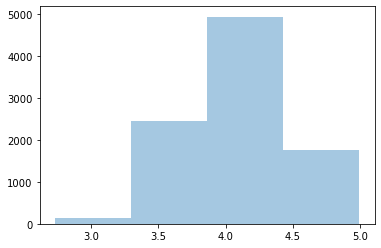

In [91]:
sns.distplot(Y_pred, kde=False, bins=4)

Finally, calculate the mean squared error for the test set and see how much of an improvement it is from the baseline.

In [92]:
print('MSE:', np.mean((Y_test - Y_pred)**2) )# Enter your code here

MSE: 1.2289360770982505


For recommender systems, subjective accuracy also matters. Get some recommendations for a random user to see if they make intuitive sense.

Try using user number 200, and see what they have watched and rated highly.

In [93]:
reduced_df[reduced_df['user'] == 200].sort_values(
    ['star_rating', 'item'], ascending=[False, True]) # Enter your code here

,customer_id,product_id,product_title,star_rating,user,item
13782,35077976,B00APE1NZW,Justified Season 4,5,200,6
3910,35077976,B00821OX98,Falling Skies Season 1,5,200,47
75399,35077976,B00HB8UWCU,Escape Plan,5,200,118
98168,35077976,B0099RFVXQ,Marvel's The Avengers,5,200,140
89552,35077976,B00IMYZL2S,Thor: The Dark World,5,200,154
30831,35077976,B008BQ8YHQ,Suits Season 2,5,200,155
60712,35077976,B008BQG3RE,Falling Skies Season 2,5,200,233
101821,35077976,B00AA7O22U,The Expendables 2,5,200,265
118368,35077976,B00AMBLXP8,Ted,5,200,280
20486,35077976,B007JF8BS2,Duck Dynasty Season 1,5,200,337


As you can see, this user likes to watch comedies, romance, and light-hearted movies and dislikes drama and fantasy movies. Let's see how your model predicts movie ratings for this user.

In [94]:
def prepare_predictions(user_id, number_movies, columns):
    # Create the sparse matrix similar to the one for training data
    X = lil_matrix((number_movies, columns)).astype('float32')# Enter your code here
    movie_index_start = columns - number_movies

    # Fill out the matrix. Each row will be the same user with every possible movie.
    for row in range(number_movies):
        X[row, user_id - 1] = 1 # Enter your code here
        X[row, movie_index_start + row] = 1 # Enter your code here

    return X

user_200 = prepare_predictions(200, products.shape[0], customers.shape[0] + products.shape[0])

Now create a list of all the ratings that the model would predict for user 200 for all movies.

In [95]:
pred_200 = []
for i in range(0, user_200.shape[0], 5):
    preds = fm_predictor.predict(user_200[i:i+5].toarray())['predictions']
    p = [pred_200.append(x['score']) for x in preds]

Now loop through and predict user 200's ratings for every common video in the catalog to see which ones to recommend or not recommend. 

Create a new dataframe `titles` by using the `reduced_df` dataframe to group by the items. Use the `product_title` column and create another column `score` and add the values from `pred_200` to it.

In [96]:
titles = reduced_df.groupby('item')['product_title'].first().reset_index()
titles['score'] = pred_200

**Question:** What products got the highest score?  

**Hint**: Use the `sort_values` function to sort columns `score` and `item` and use parameter `asecnding=[False,True]`

In [97]:
titles.sort_values(['score', 'item'], ascending=[False, True])

,item,product_title,score
209,209,The Hundred-Foot Journey (Theatrical),4.539595
262,262,The Impossible,4.537935
3141,3141,The Score,4.532291
809,809,The Hundred-Foot Journey (Theatrical),4.531047
4292,4292,Toy Story 2,4.530080
...,...,...,...
803,803,The Warriors Way,3.980348
5076,5076,Drunk History Season 1,3.978236
2302,2302,Dumb And Dumber To,3.977507
4386,4386,Life After Beth,3.972282


In [98]:
# Enter your Answer here

**Question:** What can you conclude from the highly rated and lowest rated shows for the user? 

In [99]:
# Enter your Answer here

See if your recommendations have correlations with other users. Try user 201. Perform the same operations as you did for user 200.

In [100]:
user_201 = prepare_predictions(201, products.shape[0], customers.shape[0] + products.shape[0])

pred_201 = []
for i in range(0, user_201.shape[0], 5):
    preds = fm_predictor.predict(user_201[i:i+5].toarray())['predictions']
    p = [pred_201.append(x['score']) for x in preds]

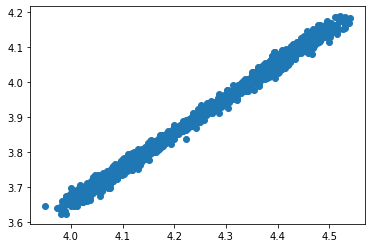

In [101]:
plt.scatter(pred_200, pred_201)
plt.show()

**Question:** What can you conclude from the scatter plot between the two users?  

In [102]:
# Enter your answer here:

Delete the endpoint you created for inference because you won't be using it anymore.

In [103]:
sagemaker.Session().delete_endpoint(fm_predictor.endpoint)

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


## <span style="color:red"> End of Lab 3 </span>

Save the project file to your local computer. Follow these steps:

1. At the top of the page, click the **File** menu. 

1. Select **Download as**, and click **Notebook(.ipynb)**.  

This downloads the current notebook to the default download folder on your computer.

# Iteration II

# Step 4: Feature engineering

You've now gone through one iteration of training and evaluating your model. Given that the outcome you reached for your model the first time probably wasn't sufficient for solving your business problem, what are some things you could change about your data to possibly improve model performance?

### Key questions to consider:
1. How might changing the machine learning problem help your dataset? You tried to use regression to solve the problem; can classification help?
2. What do you need to do to change the machine learning problem to a machine learning classification problem? Write down the new problem statement for classification.

#### <span style="color: blue;">Project presentation: Record key decisions and methods you use in this section in your project presentations, as well as any new performance metrics you obtain after evaluating your model again.</span>

Now change the training datasets to have a binary output depending on the rating they get. You will consider recommending something to a user when the rating is 5 stars, and you will save again as a protobuf format in Amazon S3. Do the following:  

1. Use the `loadDataset` function with the option `regression=False` to create your training datasets.   
2. Write the dataset as a protobuf format.  
3. Retrain the model using `predictor_type='binary_classifier'`.   
4. Deploy your model to an endpoint and evaluate the model, similar to how you did before on the test set.   
5. Inspect how you did on the test set using a confusion matrix.   

In [114]:
# X_train, Y_train = loadDataset(train_df, customers.shape[0], products.shape[0])  # Enter your code here
X_train_class, Y_train_class = loadDataset(train_df, customers.shape[0], products.shape[0], regressor=False)
X_test_class, Y_test_class = loadDataset(test_df, customers.shape[0], products.shape[0],  regressor=False)

In [115]:
# Write dataset as a protobuf
fm_train_data_path = writeDatasetToProtobuf(X_train_class, bucket, prefix, 'train_class', "sparse", Y_train_class) # Enter your code here    
fm_test_data_path  = writeDatasetToProtobuf(X_test_class, bucket, prefix, 'test_class', "sparse", Y_test_class) # Enter your code here    
  
print("Training data S3 path: ", fm_train_data_path)
print("Test data S3 path: ", fm_test_data_path)

Training data S3 path:  s3://qls-4019912-5ead0778b062168c-labbucket-1h2g0kyyebu6d/sagemaker-fm/train_class
Test data S3 path:  s3://qls-4019912-5ead0778b062168c-labbucket-1h2g0kyyebu6d/sagemaker-fm/test_class


### Sample code

```
fm_train_data_path = writeDatasetToProtobuf(X_train_class, bucket, prefix, 'train_class', "sparse", Y_train_class)    
fm_test_data_path  = writeDatasetToProtobuf(X_test_class, bucket, prefix, 'test_class', "sparse", Y_test_class) 
```

Finally, retrain the model, changing from regression to binary classification. Use the same code and settings that you did when you trained your model previously, but change the `predictor_type='binary_classifier`.

In [116]:
from sagemaker import get_execution_role
from sagemaker import image_uris

output_prefix = 's3://' + bucket + '/sagemaker-fm/model'
instance_type='ml.m4.xlarge'
batch_size = 512

fm = sagemaker.estimator.Estimator(
    image_uris.retrieve("factorization-machines", boto3.Session().region_name),
    role,
    instance_count=1, 
    instance_type=instance_type,
    output_path=output_prefix,
    sagemaker_session=sagemaker.Session()
)

fm.set_hyperparameters(feature_dim=X_train.shape[1],
                       predictor_type='binary_classifier',
                       mini_batch_size=batch_size,
                       num_factors=128,
                       epochs=25,
                       clip_gradient=5.0,
                       rescale_grad=1.0/batch_size)

fm.fit({'train': fm_train_data_path, 'test': fm_test_data_path})

2021-03-11 20:41:23 Starting - Starting the training job...
2021-03-11 20:41:46 Starting - Launching requested ML instancesProfilerReport-1615495283: InProgress
.........
2021-03-11 20:43:07 Starting - Preparing the instances for training......
2021-03-11 20:44:17 Downloading - Downloading input data...
2021-03-11 20:44:47 Training - Downloading the training image...
2021-03-11 20:45:07 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
/opt/amazon/lib/python3.7/site-packages/jsonref.py:8: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, MutableMapping, Sequence
/opt/amazon/lib/python3.7/site-packages/algorithm/network_builder.py:87: DeprecationWarning: invalid escape sequence \s
  """
/opt/amazon/lib/python3.7/site-packages/a

### Sample code 
```
from sagemaker import get_execution_role
from sagemaker import image_uris

#output_prefix= 's3://<LabBucketName>/sagemaker-fm/model'

output_prefix = 's3://' + bucket + '/sagemaker-fm/model'
instance_type='ml.m4.xlarge'
batch_size = 512

fm = sagemaker.estimator.Estimator(
    image_uris.retrieve("factorization-machines",boto3.Session().region_name),
    role, 
    instance_count=1, 
    instance_type=instance_type,
    output_path=output_prefix,
    sagemaker_session=sagemaker.Session()
)

fm.set_hyperparameters(feature_dim=X_train.shape[1],
                     # predictor_type='regressor',
                       predictor_type='binary_classifier',
                       mini_batch_size=batch_size,
                       num_factors=128,
                       epochs=25,
                       clip_gradient=5.0,
                       rescale_grad=1.0/batch_size
                       )

fm.fit({'train': fm_train_data_path, 'test': fm_test_data_path})
```

Evaluate the performance of this new model. Deploy the model, determine a serializer, and then pass the test data.

In [117]:
from sagemaker import deserializers
fm_predictor = fm.deploy(initial_instance_count=1, 
                         instance_type='ml.m4.xlarge', 
                         serializer=fm_serializer, 
                         deserializer=JSONDeserializer())

---------------!

In [119]:
# Pass the testing data to the classifier and get all the predictions
Y_pred = []
for i in range(0, X_test_class.shape[0], 5):
    preds = fm_predictor.predict(X_test_class[i:i+5].toarray())['predictions']
    p = [Y_pred.append(x['score']) for x in preds]

#### Inspect the results

To inspect how well the classifier is doing, calculate and plot a confusion matrix. Use the implementation from **Scikit-Learn**.

In [120]:
from sklearn.metrics import confusion_matrix

[[3465  994]
 [1840 2959]]


<AxesSubplot:>

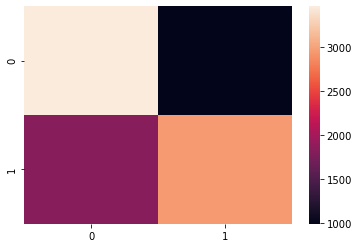

In [121]:
true = Y_test_class.astype(int)
predicted = [1 if value > 0.5 else 0 for value in Y_pred]
conf_matrix = confusion_matrix(true, predicted)
print(conf_matrix)
sns.heatmap(conf_matrix)

**Question:** What is the accuracy of your model?  

**Hint**:
$$ Accuracy = \frac{TP + TN}{TP + FP + FN + TN} $$

In [123]:
# Accuracy
tn, fp, fn, tp = conf_matrix.ravel()
acc = (tp + tn)/(tp + fp + fn + tn)
acc

0.6938863685461223

**Question:** How did your model do compared to a naive baseline model of predicting everything as 1?

In [124]:
(reduced_df.star_rating > 4).value_counts() / reduced_df.shape[0] * 100

False    50.536109
True     49.463891
Name: star_rating, dtype: float64

In [125]:
# Enter your answer here

In [126]:
# Delete inference endpoint
sagemaker.Session().delete_endpoint(fm_predictor.endpoint)

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


## Combining powers with KNN

You saw that your classifier model is doing a better job than the regressor model. Now, see if you can repackage it to fit a k-nearest neighbor (KNN) model to predict the *k closest* items to the one a customer likes and then recommend those, instead of predicting the ratings (regressor) or whether a user would like a movie or not (binary classification).

Start by downloading the model from Amazon S3. Then, repackage it to fit a KNN model.

**Note:** Make sure the kernel you are using is `conda_mxnet_p36` so you can run the next cells.

### Download model data

In [ ]:
import mxnet as mx
model_file_name = 'model.tar.gz'
model_full_path = f'{fm.output_path}/{fm.latest_training_job.job_name}/output/{model_file_name}'
print(f'Model Path: {model_full_path}')

# Download FM model 
os.system('aws s3 cp ' + model_full_path + ' .')

# Extract model file for loading to MXNet
os.system('tar xzvf ' + model_file_name)
os.system('unzip -o model_algo-1')
os.system('mv symbol.json model-symbol.json')
os.system('mv params model-0000.params')

### Extract model data to create item and user latent matrixes

Now you are going to extract the values that represent each user and item after training a factorization machine. The result of the training is two matrices that, when multiplied together, will represent the target values (zero or one) as closely as possible.

In more mathematical terms, factorization machines model output consists of three N-dimensional arrays (ndarrays):

    V – a (N x k) matrix, where:
        k is the dimension of the latent space
        N is the total count of users and items
    w – an N-dimensional vector
    b – a single number: the bias term

To extract these values, which you will use as features, you need to first load the model. Then, extract the values of each of the three matrices and build the `knn_item_matrix` and t`knn_user_matrix` matrices.

In [ ]:
# Extract model data
m = mx.module.Module.load('./model', 0, False, label_names=['out_label'])
V = m._arg_params['v'].asnumpy()
w = m._arg_params['w1_weight'].asnumpy()
b = m._arg_params['w0_weight'].asnumpy()

nb_users = customers.shape[0]
nb_item = products.shape[0]

# Item latent matrix - concat(V[i], w[i]).  
knn_item_matrix = np.concatenate((V[nb_users:], w[nb_users:]), axis=1)
knn_train_label = np.arange(1,nb_item+1)

# User latent matrix - concat (V[u], 1) 
ones = np.ones(nb_users).reshape((nb_users, 1))
knn_user_matrix = np.concatenate((V[:nb_users], ones), axis=1)

## Building KNN model

Now that you have the training data, you can now feed it to a KNN model. As you did before, you need to save the protobuf IO formatted data to Amazon S3, instantiate the model, and set the hyperparameters.

Start by setting up the path and the estimator.

In [ ]:
print('KNN train features shape = ', knn_item_matrix.shape)
knn_prefix = 'knn'
train_key = 'train_knn'
knn_output_prefix  = f's3://{bucket}/{knn_prefix}/output'
knn_train_data_path = writeDatasetToProtobuf(knn_item_matrix, bucket, 
                                             knn_prefix, train_key, 
                                             "dense", 
                                             knn_train_label)
print(f'Uploaded KNN train data: {knn_train_data_path}')

nb_recommendations = 100

# Set up the estimator
knn = sagemaker.estimator.Estimator(
    image_uris.retrieve("knn",boto3.Session().region_name),
    get_execution_role(),
    instance_count=1,
    instance_type=instance_type,
    output_path=knn_output_prefix,
    sagemaker_session=sagemaker.Session()
)

Now, you will set the hyperparameters. Note that this approach uses the default `index_type` parameter for KNN. It is precise but can be slow for large datasets. In such cases, you may want to use a different `index_type` parameter leading to an approximate, yet faster answer.

For more information about index types, see [k-NN Hyperparameters](https://docs.aws.amazon.com/sagemaker/latest/dg/kNN_hyperparameters.html).

In [ ]:
knn.set_hyperparameters(feature_dim=knn_item_matrix.shape[1], 
                        k=nb_recommendations, 
                        index_metric="INNER_PRODUCT", 
                        predictor_type='classifier', 
                        sample_size=200000)


knn.fit({'train': knn_train_data_path})

Now that you have a trained model, save it so you can reference it for batch inference.

In [ ]:
knn_model_name =  knn.latest_training_job.job_name
print("created model: ", knn_model_name)

# Save the model so that you can reference it in the next step during batch inference
sm = boto3.client(service_name='sagemaker')
primary_container = {
    'Image': knn.image_name,
    'ModelDataUrl': knn.model_data,
}

knn_model = sm.create_model(
        ModelName = knn.latest_training_job.job_name,
        ExecutionRoleArn = knn.role,
        PrimaryContainer = primary_container)
print("saved the model")

## Batch transform

To see the predictions your model made, you would have to create inferences and see if they make sense. You could repeat the process as last time and check one user at a time with all possible combinations of items. However, Amazon SageMaker provides a batch transform job that you can use to do inference over the entire dataset. For more information, see [Get Inferences for an Entire Dataset with Batch Transform](https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-batch.html).

In this section, you will use a batch transform to predict the top 100 recommendations for all the users.

In [ ]:
# Upload inference data to S3
knn_batch_data_path = writeDatasetToProtobuf(knn_user_matrix,
                                             bucket, 
                                             knn_prefix, 
                                             train_key, 
                                             "dense")
print ("Batch inference data path: ",knn_batch_data_path)

# Initialize the transformer object
transformer =sagemaker.transformer.Transformer(
    base_transform_job_name="knn",
    model_name=knn_model_name,
    instance_count=1,
    instance_type=instance_type,
    output_path=knn_output_prefix,
    accept="application/jsonlines; verbose=true",
    
)

# Start a transform job
transformer.transform(knn_batch_data_path, 
                      content_type='application/x-recordio-protobuf',
                      split_type='RecordIO')
transformer.wait()

 

You are now free to examine the predictions. Download them first.

In [ ]:
# Download predictions 
results_file_name = "inference_output"
inference_output_file = "knn/output/train_knn.out"
s3_client = boto3.client('s3')
s3_client.download_file(bucket, inference_output_file, results_file_name)

In [ ]:
# Open file and load it to memory
with open(results_file_name) as f:
    results = f.readlines() 

The results contain the 100 nearest neighbor movie IDs with their corresponding distances. See how it looks for user number 200.

In [ ]:
test_user_idx = 200
u_one_json = json.loads(results[test_user_idx])
recommended_movies = [int(movie_id) for movie_id in u_one_json['labels']]
distances = [round(distance, 4) for distance in u_one_json['distances']]

print(f'Recommended movie Ids for user #{test_user_idx} : {recommended_movies}')

print(f'Movie distances for user #{test_user_idx} : {distances}')

You got the movies closest to user 200's tastes. Now, you can see the titles.

In [ ]:
titles_200 = reduced_df[reduced_df.item.isin(recommended_movies)].product_title.unique()
titles_200

Compare them with the favorite movies for user 200.

In [ ]:
reduced_df.query('user==200 & star_rating == 5')

**Question:** Do you think these recommendations make sense? Explain why or why not.

In [ ]:
# Enter your answer here:

In [ ]:
np.isin(titles_200, titles.tail(100).product_title.unique()).sum()

**Super bonus question:** Recover the predictions for user 201, and see how they compare with user 200. Are they still correlated? Do you think this approach was an improvement over the first regressor?

In [ ]:
# Recover the predictions for user 201

test_user_idx = 201
u_one_json = json.loads(results[test_user_idx])
recommended_movies_201 = [int(movie_id) for movie_id in u_one_json['labels']]

In [ ]:
# Print out recommendations

titles_201 = reduced_df[reduced_df.item.isin(recommended_movies_201)].product_title.unique()
titles_201

In [ ]:
# Compare the two predictions

overlap = np.isin(titles_200, titles_201).sum()
print(f'The recommendations for "user 201" that are present in "user 200" are: {overlap} out of: {len(titles_200)}')

In [ ]:
# Compare with user 201 likes

reduced_df.query('user==201 & star_rating == 5')

In [ ]:
test_user_idx = 900
u_one_json = json.loads(results[test_user_idx])
recommended_movies_900 = [int(movie_id) for movie_id in u_one_json['labels']]
titles_900 = reduced_df[reduced_df.item.isin(recommended_movies_201)].product_title.unique()
overlap_900 = np.isin(titles_200, titles_900).sum()
print(f'The recommendations for "user 900" that are present in "user 200" are: {overlap} out of: {len(titles_200)}')
reduced_df.query('user==900 & star_rating == 5')

In [ ]:
# Enter your answer here:

There are a number of things you can do to improve these models, such as adding features besides rating, trying different feature selection, hyperparameter tuning, and changing the models. The most sophisticated recommendation algorithms are based on deep learning. This can also be explored.

That is it! You now have a working recommender system that can tell you the top 100 movies for a user. Feel free to optimize and play with the hyperparameters and data to see if you can create an even better recommender system.

## Final thoughts

In this notebook, you used different techniques to create a recommendations system using only Amazon SageMaker built-in algorithms. You learned how to prepare data in different formats and do feature engineering. You were able to identify problems with your trained models and reframe the problem in different ways to achieve an end result. 

As you can see now, training a model requires a lot of steps, preparation, and validation. It is not a streamlined process but an iterative one. You can think of this as a virtuous cycle that usually has the following steps:

- Define the (business) problem.
- Frame the problem as a machine learning problem.
- Prepare data and perform freature engineerin.
- Train and evaluate the model.
- Deploy the model (inference).
- Monitor and evaluate.

Every step has its own challenges, and each of the steps feeds each other. So it is important to pay attention to the entire pipeline, not only the model training.
